# Artificial Intelligence generated views on the Black-Litterman model

## Import required packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

### Graph Formatting

In [2]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize = (10,6))         # size fo the graph

## Import the data

Categories construction: Assigns each NYSE, AMEX, and NASDAQ stock to an industry portfolio at the end of June of year t based on its four-digit SIC code at that time. (Uses Compustat SIC codes for the fiscal year ending in calendar year t-1. Whenever Compustat SIC codes are not available, uses CRSP SIC codes for June of year t.) Then computes returns from July of t to June of t+1
 
 1. NoDur  Consumer Nondurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys
 2. Durbl  Consumer Durables -- Cars, TVs, Furniture, Household Appliances
 3. Manuf  Manufacturing -- Machinery, Trucks, Planes, Chemicals, Off Furn, Paper, Com Printing
 4. Enrgy  Oil, Gas, and Coal Extraction and Products
 5. HiTec  Business Equipment -- Computers, Software, and Electronic Equipment
 6. Telcm  Telephone and Television Transmission
 7. Shops  Wholesale, Retail, and Some Services (Laundries, Repair Shops)
 8. Hlth   Healthcare, Medical Equipment, and Drugs
 9. Utils  Utilities
 10. Other -- Other Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment, Finance

Source: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_10_ind_port.html

In [3]:
class DataImporter:
    excel_file = "10_Industry_Portfolios.xlsx"

    def __init__(self, split_percent=0.9):
        self.raw = {}
        self.raw['rets'] = self.get_data(0)
        self.raw['nfirms'] = self.get_data(1)
        self.raw['avg_size'] = self.get_data(2)
        self.raw['mktcap'] = pd.DataFrame(self.raw['nfirms'] *
                                          self.raw['avg_size'])
        self.raw['w'] = self.calculate_weights()
        self.n_industries = len(self.raw['rets'].columns)
        self.industries = self.raw['rets'].columns
        self.divide_data(split_percent)

    def get_data(self, sheet):
        raw = pd.read_excel(self.excel_file, header=0,
                            index_col=0, na_values=-99.99,
                            sheet_name=sheet, engine='openpyxl')/100
        raw.index = pd.to_datetime(raw.index, format="%Y%m").to_period('M')
        return raw

    def aux_division(self, split, parameter):
        self.train[parameter] = self.raw[parameter].iloc[:split].copy()
        self.test[parameter] = self.raw[parameter].iloc[split:].copy()

    def divide_data(self, split_percent):
        split = int(len(self.raw['rets']) * split_percent)
        self.train = {}
        self.test = {}
        self.aux_division(split, 'rets')
        self.aux_division(split, 'nfirms')
        self.aux_division(split, 'avg_size')
        self.aux_division(split, 'mktcap')
        self.aux_division(split, 'w')

    def calculate_weights(self):
        total_mktcap = self.raw['mktcap'].sum(axis=1)
        ind_weight = self.raw['mktcap'].divide(total_mktcap, axis=0)
        return ind_weight
        

In [4]:
original_data = DataImporter()

In [5]:
original_data.train['rets'].tail()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
2011-04,0.0459,0.0222,0.0299,0.0130,0.0311,0.0341,0.0453,0.0638,0.0399,0.0111
2011-05,0.0193,-0.0354,-0.0215,-0.0456,-0.0166,0.0077,0.0083,0.0197,0.0130,-0.0239
2011-06,-0.0101,-0.0123,-0.0059,-0.0249,-0.0233,-0.0124,-0.0089,-0.0183,-0.0034,-0.0206
2011-07,-0.0043,-0.0891,-0.0470,0.0051,-0.0037,-0.0503,-0.0067,-0.0365,-0.0035,-0.0376
2011-08,-0.0068,-0.1200,-0.0609,-0.1011,-0.0689,-0.0545,-0.0288,-0.0310,0.0014,-0.0761


## Explore the data

In [6]:
nf = pd.DataFrame(original_data.train['nfirms'].tail(1).T)
nf.columns = ["nfirms"]
avs = pd.DataFrame(original_data.train['avg_size'].tail(1).T)
avs.columns=["avg_size"]
mcap = pd.DataFrame(original_data.train['mktcap'].tail(1).T)
mcap.columns=["mktcap"]
aux_plot = pd.concat([nf, avs,mcap], axis=1)
aux_plot.round(1)

,nfirms,avg_size,mktcap
NoDur,1.7,58.5,100.7
Durbl,1.0,24.5,23.5
Manuf,4.6,38.5,176.4
Enrgy,1.7,89.2,151.7
HiTec,6.9,42.6,292.4
Telcm,1.0,78.7,79.5
Shops,3.4,40.1,136.5
Hlth,4.6,29.2,133.6
Utils,1.0,59.8,59.8
Other,11.8,31.5,370.5


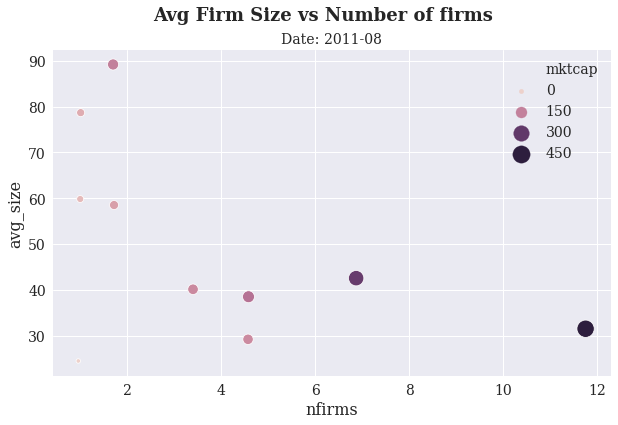

In [7]:
train_date =  original_data.train['nfirms'].tail(1).index[0]
f, ax = plt.subplots()
f.suptitle('Avg Firm Size vs Number of firms',fontweight="bold")
ax.set_title("Date: " + str(train_date))
ax.set_xlabel('# of firms')
ax.set_ylabel('Average Size')
sns.scatterplot(x="nfirms", y="avg_size", hue="mktcap", size="mktcap",sizes=(20, 300),
                data=aux_plot, ax=ax);

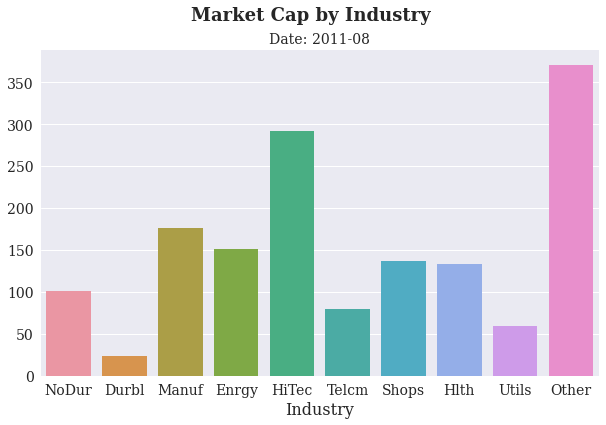

In [8]:
fig, ax = plt.subplots()
fig.suptitle('Market Cap by Industry',fontweight="bold")
ax.set_title("Date: " + str(train_date))
ax.set_xlabel('Industry')
sns.barplot(data=original_data.train['mktcap'].tail(1));

In [9]:
original_data.train['rets'].describe()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,0.009713,0.010794,0.010155,0.010631,0.010799,0.008327,0.009902,0.010616,0.008805,0.008794
std,0.046867,0.078084,0.063800,0.061173,0.074262,0.046643,0.059612,0.056860,0.056538,0.065589
min,-0.246900,-0.348000,-0.298200,-0.298400,-0.338700,-0.215600,-0.302400,-0.340800,-0.330500,-0.300300
25%,-0.014000,-0.027775,-0.020900,-0.023700,-0.028075,-0.013850,-0.021500,-0.019875,-0.016875,-0.021975
50%,0.010950,0.010050,0.013800,0.008900,0.012600,0.009000,0.011150,0.010850,0.010500,0.012450
75%,0.036700,0.048400,0.043275,0.046175,0.050675,0.032075,0.041325,0.040850,0.036275,0.042500
max,0.341700,0.797900,0.572000,0.389900,0.534900,0.281700,0.424500,0.371300,0.434600,0.587500


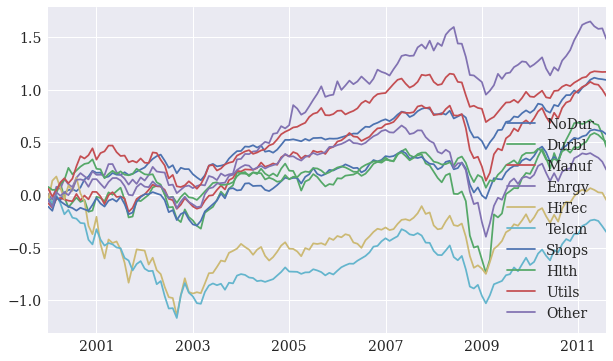

In [10]:
# fig, ax = plt.subplots()
# sns.lineplot(data=original_data.train['rets'].loc["2000-01":,].cumsum());
original_data.train['rets'].loc["2000-01":,].cumsum().plot();

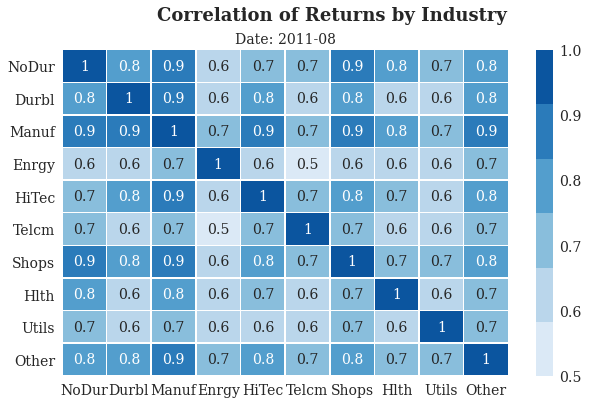

In [11]:
fig, ax = plt.subplots()
fig.suptitle('Correlation of Returns by Industry',fontweight="bold")
ax.set_title("Date: " + str(train_date))
sns.heatmap(original_data.train['rets'].corr().round(1),
            cmap=sns.color_palette('Blues'), annot=True, linewidths=.5, ax=ax);

## Calculate expected Returns

In [12]:
views = {}

In [13]:
views['v'] = 1  # number of views

In [14]:
views['P'] = np.zeros((views['v'], 10))
views['P'][0, 0] = 1 # view on 'NoDur'
views['P'][0, 2] = -1 # view on 'Manuf'
views['P']

array([[ 1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [15]:
views['q'] = np.zeros(views['v'])
views['q'][0] = 0.02
views['q']

array([0.02])

In [16]:
views['omega'] = np.zeros((views['v'], views['v']))
views['omega'][0, 0] = 0.000001  # "no" variance

## Calculate Black Litterman Returns

In [17]:
class BlackLitterman(DataImporter):

    def __init__(self, views, split_percent=0.9,
                 delta=3, tau=1, rf=0.02):
        super().__init__(split_percent)
        self.cov = {}
        self.returns = {}
        self.excess_returns = {}
        self.cov['historical'] = self.train['rets'].cov() * 12
        self.returns['historical'] = pd.DataFrame(self.train['rets'].mean() *
                                                  12, columns=['historical'])
        self.calculate_eq(rf, delta)
        self.calculate_bl(tau, views, rf)

    def calculate_eq(self, rf, delta):
        self.returns['equilibrium'] = \
        pd.DataFrame(delta * np.dot(self.cov['historical'],
                     self.train['w'].tail(1).T), columns=['equilibrium'],
                     index=self.industries)
        self.excess_returns['equilibrium'] = \
        (self.returns['equilibrium'].values - rf).reshape((self.n_industries,))

    def calculate_bl(self, tau, views, rf):
        # Calculate 2 intermediate variables m1 and m2
        # m1 is related to the views
        m1 = np.dot(views['P'].T, np.dot(1 / views['omega'], views['P'])) + \
        np.linalg.inv(tau * self.cov['historical'])
        # m2 is related to the equilibrium returns
        m2 = np.dot(views['P'].T, np.dot(1 / views['omega'], views['q'])) + \
        np.dot(np.linalg.inv(tau * self.cov['historical']),
               self.excess_returns['equilibrium'])
        # Calculate the excess return with the previously calculated m1, m2
        self.excess_returns['black_litterman'] = np.dot(np.linalg.inv(m1), m2)
        # Calculate the returns adding rf to the excess returns
        self.returns['black_litterman'] = \
        pd.DataFrame(self.excess_returns['black_litterman'] + rf,
                     columns=['black_litterman'], index=self.industries)
        # Calculate the new covariance matrix
        self.cov['black_litterman'] = \
        self.cov['historical'] + np.linalg.inv(m1)


In [18]:
BL = BlackLitterman(views)

Recall that the first step in the Black Litterman procedure was to reverse engineer the implied returns vector $\pi$ from a set of portfolio weights $w$. 

$$\pi = \delta\Sigma w$$


In [19]:
BL.returns['equilibrium']

,equilibrium
NoDur,0.084478
Durbl,0.135166
Manuf,0.123809
Enrgy,0.094358
HiTec,0.137184
Telcm,0.071492
Shops,0.107817
Hlth,0.094674
Utils,0.087571
Other,0.125971


Assume that we have $N$ assets, and $K$ views. There are two sets of inputs to the procedure. The first set of inputs relate to market parameters and these are:

\begin{array}{ll}
w & \mbox{A Column Vector ($N \times 1$) of Equilibrium Market Weights of the Assets} \\
\Sigma & \mbox{A Covariance Matrix ($N \times N$) of the Assets} \\
R_f & \mbox{The Risk Free Rate} \\
\delta & \mbox{The investor's Risk Aversion parameter}  \\
\tau & \mbox{A scalar indicating the uncertainty of the prior (details below)}
\end{array}

The second set of inputs that the procedure needs is a representation of the investors views. These are specified via:

\begin{array}{ll}
Q & \mbox{An $K \times 1$ ``Qualitative Views'' or simply, Views matrix} \\
P & \mbox{A $K \times N$ ``Projection'' or ``Pick'' matrix, linking each view to the assets} \\
\Omega & \mbox{A Covariance matrix representing the uncertainty of views}
\end{array}

The posterior returns and covariances are obtained from the _Black-Litterman Master Formula_ which is the following set of equations:

\begin{equation}
\label{eq:blMuOrig}
\mu^{BL} = [(\tau\Sigma)^{-1} + P \Omega^{-1} P]^{-1}[(\tau\Sigma)^{-1} \pi + P \Omega^{-1} Q]
\end{equation}


\begin{equation}
\label{eq:blSigmaOrig}
\Sigma^{BL} = \Sigma + [(\tau\Sigma)^{-1} + P \Omega^{-1} P]^{-1}
\end{equation}

In [20]:
pd.concat([BL.returns['historical'], BL.returns['equilibrium'],BL.returns['black_litterman']], axis=1)

,historical,equilibrium,black_litterman
NoDur,0.116550,0.084478,0.066329
Durbl,0.129532,0.135166,0.053192
Manuf,0.121855,0.123809,0.046334
Enrgy,0.127571,0.094358,0.039519
HiTec,0.129591,0.137184,0.059702
Telcm,0.099923,0.071492,0.042863
Shops,0.118825,0.107817,0.066784
Hlth,0.127390,0.094674,0.063296
Utils,0.105662,0.087571,0.053962
Other,0.105533,0.125971,0.065191


In [21]:
BL.cov['black_litterman']

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
NoDur,0.051411,0.060006,0.055679,0.039317,0.056278,0.033501,0.055395,0.049183,0.042784,0.058206
Durbl,0.060006,0.119696,0.079285,0.053216,0.083118,0.046220,0.076296,0.057846,0.055602,0.079364
Manuf,0.055679,0.079285,0.073900,0.052215,0.074501,0.040234,0.065046,0.056563,0.050689,0.072500
Enrgy,0.039317,0.053216,0.052215,0.077892,0.050937,0.028990,0.043172,0.040844,0.044758,0.053897
HiTec,0.056278,0.083118,0.074501,0.050937,0.108562,0.048289,0.071810,0.063613,0.052852,0.075021
Telcm,0.033501,0.046220,0.040234,0.028990,0.048289,0.048966,0.040699,0.034874,0.036507,0.044948
Shops,0.055395,0.076296,0.065046,0.043172,0.071810,0.040699,0.078611,0.055414,0.047768,0.067863
Hlth,0.049183,0.057846,0.056563,0.040844,0.063613,0.034874,0.055414,0.073691,0.044232,0.058683
Utils,0.042784,0.055602,0.050689,0.044758,0.052852,0.036507,0.047768,0.044232,0.072240,0.057301
Other,0.058206,0.079364,0.072500,0.053897,0.075021,0.044948,0.067863,0.058683,0.057301,0.088604


## Find Optimal Weight

In [126]:
class OptimalWeights(BlackLitterman):

    def __init__(self, views, split_percent=0.9,
                 delta=3, tau=1, rf=0.02):
        super().__init__(views, split_percent,
                 delta, tau, rf)
        self.rf = rf
        
        self.equal_weights = self.n_industries * [1 / self.n_industries]

    def calculate_return(self, weights,returns):
        returns = returns.values.reshape(self.n_industries,)
        return np.dot(returns,weights)

    def calculate_std_dev(self, weights,cov):
        return math.sqrt(np.dot(weights, np.dot(cov, weights)))


    def calculate_sharpe(self, weights, returns):
        returns = returns.values.reshape(self.n_industries,)
        return (calculate_return(weights,returns) - self.rf) / calculate_std_dev(weights,returns)
    
    
    def calculate_metrics(self, weights, returns, cov):
        metrics = {}
        metrics['return'] = self.calculate_return(weights,returns)
        metrics['cov'] = self.calculate_std_dev(weights,cov)
        metrics['sharpe'] = metrics['return'] - self.rf / metrics['cov']
        return metrics
        
        
    def _set_bounds_constraints(self, bnds, cons):
        if bnds is None:
            self.bnds = self.no_assets * [(0, 1)]
        else:
            self.bnds = bnds
        if cons is None:
            self.cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}
        else:
            self.cons = cons
    
    def minimum_volatility_portfolio(self, opt_returns, bnds=None, cons=None):
        self._set_bounds_constraints(bnds, cons)
        opt = minimize(self.portfolio_volatility, weights=self.equal_weights,
                  args = (opt_returns),
                   bounds=self.bnds, constraints=self.cons)
        solution = pd.DataFrame(opt['x'], index=self.universe, columns=['weights',])
#         self.results = self._get_results(opt, 'Minimum Volatility')
        return solution

In [127]:
OPT = OptimalWeights(views)

In [128]:
OPT.returns['historical']

,historical
NoDur,0.116550
Durbl,0.129532
Manuf,0.121855
Enrgy,0.127571
HiTec,0.129591
Telcm,0.099923
Shops,0.118825
Hlth,0.127390
Utils,0.105662
Other,0.105533


In [129]:
OPT.calculate_metrics(OPT.equal_weights,OPT.returns['historical'],OPT.cov['historical'])

{'return': 0.11824320939334641,
 'cov': 0.1832596455608185,
 'sharpe': 0.009108435402077356}